### Uczenie maszynowe
# 3. Regresja liniowa – część 2

## 3.1. Regresja liniowa wielu zmiennych

Do przewidywania wartości $y$ możemy użyć więcej niż jednej cechy $x$:

### Przykład – ceny mieszkań

In [2]:
import numpy as np
import pandas as pd

data = pd.read_csv("data_flats_train.tsv", sep="\t")
data.rename(
    columns={
        col: f"x{i}:{col}" if i > 0 else f"y:{col}"
        for i, col in enumerate(data.columns)
    },
    inplace=True,
)
data.index = np.arange(1, len(data) + 1)
print(data)


       y:price  x1:isNew  x2:rooms  x3:floor   x4:location  x5:sqrMetres
1     476118.0     False         3         1       Centrum            78
2     459531.0     False         3         2        Sołacz            62
3     411557.0     False         3         0        Sołacz            15
4     496416.0     False         4         0        Sołacz            14
5     406032.0     False         3         0        Sołacz            15
...        ...       ...       ...       ...           ...           ...
1335  349000.0     False         4         0  Szczepankowo            29
1336  399000.0     False         5         0  Szczepankowo            68
1337  234000.0      True         2         7         Wilda            50
1338  210000.0      True         2         1         Wilda            65
1339  279000.0      True         2         2        Łazarz            36

[1339 rows x 6 columns]


$$ x^{(2)} = ({\rm "False"}, 3, 2, {\rm "Sołacz"}, 62), \quad x_3^{(2)} = 2 $$

### Hipoteza

W naszym przypadku (wybraliśmy 5 cech):

$$ h_\theta(x) = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \theta_3 x_3 + \theta_4 x_4 + \theta_5 x_5 $$

W ogólności ($n$ cech):

$$ h_\theta(x) = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \ldots + \theta_n x_n $$

Jeżeli zdefiniujemy $x_0 = 1$, będziemy mogli powyższy wzór zapisać w bardziej kompaktowy sposób:

$$
\begin{array}{rcl}
h_\theta(x)
 & = & \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + \ldots + \theta_n x_n \\
 & = & \displaystyle\sum_{i=0}^{n} \theta_i x_i \\
 & = & \theta^T \, x \\
 & = & x^T \, \theta \\
\end{array}
$$

($x$ oznacza pojedynczy przykład ze zbioru uczącego).

### Metoda gradientu prostego – notacja macierzowa

Metoda gradientu prostego przyjmie bardzo elegancką formę, jeżeli do jej zapisu użyjemy wektorów i macierzy.

$$
X=\left[\begin{array}{cc}
1 & \left( \vec x^{(1)} \right)^T \\
1 & \left( \vec x^{(2)} \right)^T \\
\vdots & \vdots\\
1 & \left( \vec x^{(m)} \right)^T \\
\end{array}\right] 
= \left[\begin{array}{cccc}
1 & x_1^{(1)} & \cdots & x_n^{(1)} \\
1 & x_1^{(2)} & \cdots & x_n^{(2)} \\
\vdots & \vdots & \ddots & \vdots\\
1 & x_1^{(m)} & \cdots & x_n^{(m)} \\
\end{array}\right]
\quad
\vec{y} = 
\left[\begin{array}{c}
y^{(1)}\\
y^{(2)}\\
\vdots\\
y^{(m)}\\
\end{array}\right]
\quad
\theta = \left[\begin{array}{c}
\theta_0\\
\theta_1\\
\vdots\\
\theta_n\\
\end{array}\right]
$$

$$h_\theta(X) = X \theta$$

($X$ oznacza macierz reprezentującą cechy wszystkich przykładów ze zbioru uczącego).

In [3]:
# Wersje macierzowe funkcji rysowania wykresów punktowych oraz krzywej regresyjnej

import matplotlib.pyplot as plt
import numpy as np


def h(theta, x):
    return x * theta


def regdots(x, y, xlabel="", ylabel=""):
    fig = plt.figure(figsize=(16 * 0.6, 9 * 0.6))
    ax = fig.add_subplot(111)
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    ax.scatter([x], [y], c="r", s=50, label="Dane")

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.margins(0.05, 0.05)
    plt.ylim(y.min() - 1, y.max() + 1)
    plt.xlim(np.min(x) - 1, np.max(x) + 1)
    return fig


def regline(fig, fun, theta, x, y, cost_fun):
    ax = fig.axes[0]
    x_min = np.min(x)
    x_max = np.max(x)
    x_range = [x_min, x_max]
    x_matrix = np.matrix([1, x_min, 1, x_max]).reshape(2, 2)
    cost = cost_fun(theta, x, y)
    ax.plot(
        x_range,
        fun(theta, x_matrix),
        linewidth="2",
        label=(
            r"$y={theta0:.1f}{op}{theta1:.1f}x, \; J(\theta)={cost:.3f}$".format(
                theta0=theta[0],
                theta1=(theta[1] if theta[1] >= 0 else -theta[1]),
                op="+" if theta[1] >= 0 else "-",
                cost=cost,
            )
        ),
    )


def legend(fig):
    ax = fig.axes[0]
    handles, labels = ax.get_legend_handles_labels()
    # try-except block is a fix for a bug in Poly3DCollection
    try:
        fig.legend(handles, labels, fontsize="15", loc="lower right")
    except AttributeError:
        pass


In [4]:
# Wczytwanie danych z pliku – regresja liniowa wielu zmiennych – notacja macierzowa

import pandas as pd

data = pd.read_csv(
    "data_flats_train.tsv",
    delimiter="\t",
    usecols=["price", "rooms", "floor", "sqrMetres"],
)
m, n_plus_1 = data.values.shape
n = n_plus_1 - 1
Xn = data.values[:, 1:].reshape(m, n)

# Dodaj kolumnę jedynek do macierzy
X = np.matrix(np.concatenate((np.ones((m, 1)), Xn), axis=1)).reshape(m, n_plus_1)
y = np.matrix(data.values[:, 0]).reshape(m, 1)

print(f"{X[:5]=}")
print(f"{X.shape=}")
print(f"{y[:5]=}")
print(f"{y.shape=}")


X[:5]=matrix([[ 1.,  3.,  1., 78.],
        [ 1.,  3.,  2., 62.],
        [ 1.,  3.,  0., 15.],
        [ 1.,  4.,  0., 14.],
        [ 1.,  3.,  0., 15.]])
X.shape=(1339, 4)
y[:5]=matrix([[476118.],
        [459531.],
        [411557.],
        [496416.],
        [406032.]])
y.shape=(1339, 1)


### Funkcja kosztu – notacja macierzowa

$$J(\theta)=\dfrac{1}{2|\vec y|}\left(X\theta-\vec{y}\right)^T\left(X\theta-\vec{y}\right)$$ 


In [5]:
from IPython.display import display, Math, Latex


def J(theta, X, y):
    """Wersja macierzowa funkcji kosztu"""
    m = len(y)
    cost = 1.0 / (2.0 * m) * ((X * theta - y).T * (X * theta - y))
    return cost.item()


theta = np.matrix([10, 90, -1, 2.5]).reshape(4, 1)

cost = J(theta, X, y)
display(Math(r"\Large J(\theta) = %.4f" % cost))


<IPython.core.display.Math object>

### Gradient – notacja macierzowa

$$\nabla J(\theta) = \frac{1}{|\vec y|} X^T\left(X\theta-\vec y\right)$$

In [6]:
# Wyświetlanie macierzy w LaTeX-u


def latex_matrix(matrix):
    ltx = r"\left[\begin{array}"
    m, n = matrix.shape
    ltx += "{" + ("r" * n) + "}"
    for i in range(m):
        ltx += r" & ".join([("%.4f" % j.item()) for j in matrix[i]]) + r" \\ "
    ltx += r"\end{array}\right]"
    return ltx


In [7]:
from IPython.display import display, Math, Latex


def dJ(theta, X, y):
    """Wersja macierzowa gradientu funckji kosztu"""
    return 1.0 / len(y) * (X.T * (X * theta - y))


theta = np.matrix([10, 90, -1, 2.5]).reshape(4, 1)

display(
    Math(
        r"\large \theta = "
        + latex_matrix(theta)
        + r"\quad"
        + r"\large \nabla J(\theta) = "
        + latex_matrix(dJ(theta, X, y))
    )
)


<IPython.core.display.Math object>

### Algorytm gradientu prostego – notacja macierzowa

$$ \theta := \theta - \alpha \, \nabla J(\theta) $$

In [8]:
def gradient_descent(fJ, fdJ, theta, X, y, alpha, eps):
    """Implementacja algorytmu gradientu prostego za pomocą numpy i macierzy"""
    current_cost = fJ(theta, X, y)
    history = [[current_cost, theta]]
    while True:
        theta = theta - alpha * fdJ(theta, X, y)  # implementacja wzoru
        current_cost, prev_cost = fJ(theta, X, y), current_cost
        if abs(prev_cost - current_cost) <= eps:
            break
        if current_cost > prev_cost:
            print("Długość kroku (alpha) jest zbyt duża!")
            break
        history.append([current_cost, theta])
    return theta, history


In [9]:
theta_start = np.zeros((n + 1, 1))

# Zmieniamy wartości alpha (rozmiar kroku) oraz eps (kryterium stopu)
theta_best, history = gradient_descent(J, dJ, theta_start, X, y, alpha=0.0001, eps=0.1)

display(
    Math(
        r"\large\textrm{Wynik:}\quad \theta = "
        + latex_matrix(theta_best)
        + (r" \quad J(\theta) = %.4f" % history[-1][0])
        + r" \quad \textrm{po %d iteracjach}" % len(history)
    )
)


<IPython.core.display.Math object>

## 3.2. Metoda gradientu prostego w praktyce

### Kryterium stopu

Algorytm gradientu prostego polega na wykonywaniu określonych kroków w pętli. Pytanie brzmi: kiedy należy zatrzymać wykonywanie tej pętli?

W każdej kolejnej iteracji wartość funkcji kosztu maleje o coraz mniejszą wartość.
Parametr `eps` określa, jaka wartość graniczna tej różnicy jest dla nas wystarczająca:

 * Im mniejsza wartość `eps`, tym dokładniejszy wynik, ale dłuższy czas działania algorytmu.
 * Im większa wartość `eps`, tym krótszy czas działania algorytmu, ale mniej dokładny wynik.

Na wykresie zobaczymy porównanie regresji dla różnych wartości `eps`

In [10]:
theta_start = np.zeros((n + 1, 1))

epss = [10.0**n for n in range(-1, 5)]
costs = []
lengths = []
for eps in epss:
    theta_best, history = gradient_descent(
        J, dJ, theta_start, X, y, alpha=0.0001, eps=eps
    )
    cost = history[-1][0]
    steps = len(history)
    print(f"{eps=:7},  {cost=:15.3f},  {steps=:6}")
    costs.append(cost)
    lengths.append(steps)


eps=    0.1,  cost=10324864803.159,  steps=374575
eps=    1.0,  cost=10324942127.799,  steps=176746
eps=   10.0,  cost=10325220747.014,  steps= 60389
eps=  100.0,  cost=10325742602.406,  steps= 46184
eps= 1000.0,  cost=10330453738.393,  steps= 34059
eps=10000.0,  cost=10377076139.727,  steps= 22123


In [11]:
def eps_cost_steps_plot(eps, costs, steps):
    """Wykres kosztu i liczby kroków w zależności od eps"""
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(eps, steps, "--s", color="green")
    ax2.plot(eps, costs, ":o", color="orange")
    ax1.set_xscale("log")
    ax1.set_xlabel("eps")
    ax1.set_ylabel("liczba kroków", color="green")
    ax2.set_ylabel("koszt", color="orange")
    plt.show()


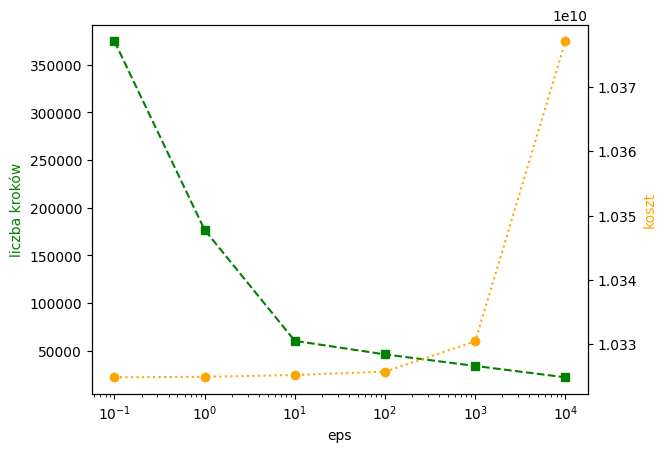

In [12]:
eps_cost_steps_plot(epss, costs, lengths)


### Długość kroku ($\alpha$)

In [13]:
import ipywidgets as widgets

# Jak zmienia się koszt w kolejnych krokach w zależności od alfa


def costchangeplot(history, return_fig=False):
    fig = plt.figure(figsize=(16 * 0.6, 9 * 0.6))
    ax = fig.add_subplot(111)
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    ax.set_xlabel("krok")
    ax.set_ylabel(r"$J(\theta)$")

    X = np.arange(0, 500, 1)
    Y = [history[step][0] for step in X]
    ax.plot(X, Y, linewidth="2", label=(r"$J(\theta)$"))
    if return_fig:
        return fig


def slide7(alpha):
    theta_best, history = gradient_descent(
        J, dJ, theta_start, X, y, alpha=0.0001, eps=0.1
    )
    fig = costchangeplot(history, return_fig=True)
    legend(fig)


sliderAlpha1 = widgets.FloatSlider(
    min=0.01, max=0.03, step=0.001, value=0.02, description=r"$\alpha$", width=300
)


In [14]:
widgets.interact_manual(slide7, alpha=sliderAlpha1)


interactive(children=(FloatSlider(value=0.02, description='$\\alpha$', max=0.03, min=0.01, step=0.001), Button…

<function __main__.slide7(alpha)>

## 3.3. Normalizacja danych

Normalizacja danych to proces, który polega na dostosowaniu danych wejściowych w taki sposób, żeby ułatwić działanie algorytmowi gradientu prostego.

Wyjaśnię to na przykladzie.

Użyjemy danych z „Gratka flats challenge 2017”.

Rozważmy model $h(x) = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \theta_3 x_3$, w którym cena mieszkania prognozowana jest na podstawie liczby pokoi $x_1$, piętra $x_2$ i metrażu $x_3$:

In [14]:
# Dane, które wczytaliśmy na początku wykładu
print(data)


         price  rooms  floor  sqrMetres
0     476118.0      3      1         78
1     459531.0      3      2         62
2     411557.0      3      0         15
3     496416.0      4      0         14
4     406032.0      3      0         15
...        ...    ...    ...        ...
1334  349000.0      4      0         29
1335  399000.0      5      0         68
1336  234000.0      2      7         50
1337  210000.0      2      1         65
1338  279000.0      2      2         36

[1339 rows x 4 columns]


In [15]:
def show_mins_and_maxs(X):
    """Funkcja, która pokazuje wartości minimalne i maksymalne w macierzy X"""
    mins = np.amin(X, axis=0).tolist()[0]  # wartości minimalne
    maxs = np.amax(X, axis=0).tolist()[0]  # wartości maksymalne
    for i, (xmin, xmax) in enumerate(zip(mins, maxs)):
        display(Math(r"${:.2F} \leq x_{} \leq {:.2F}$".format(xmin, i, xmax)))


Cechy w danych uczących przyjmują wartości z zakresu:

In [16]:
show_mins_and_maxs(X)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

4


Jak widzimy, $x_2$ przyjmuje wartości dużo większe niż $x_1$.
Powoduje to, że wykres funkcji kosztu jest bardzo „spłaszczony” wzdłuż jednej z osi:

In [17]:
def contour_plot(X, y):
    theta0_vals = np.linspace(-1e7, 1e7, 100)
    theta1_vals = np.linspace(-1e7, 1e7, 100)

    J_vals = np.zeros(shape=(theta0_vals.size, theta1_vals.size))
    for t1, element in enumerate(theta0_vals):
        for t2, element2 in enumerate(theta1_vals):
            thetaT = np.matrix([1.0, element, element2]).reshape(3, 1)
            J_vals[t1, t2] = J(thetaT, X, y)

    plt.figure()
    plt.contour(theta0_vals, theta1_vals, J_vals.T, levels=20)
    plt.xlabel(r"$\theta_0$")
    plt.ylabel(r"$\theta_1$")


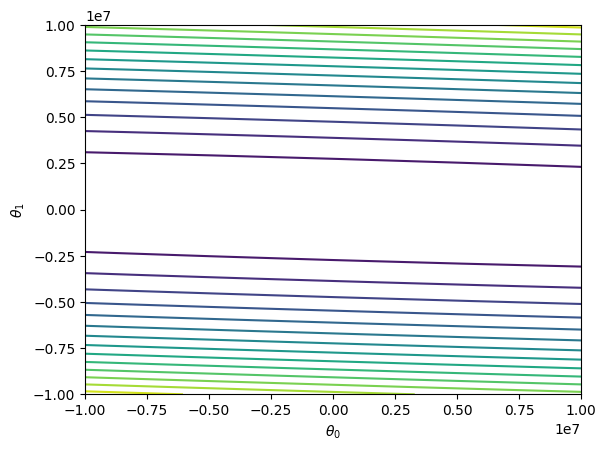

In [18]:
contour_plot(
    X[:, [0, 2, 3]], y
)  # Wybieramy cechy [0, 2, 3], bo więcej nie da się zobaczyć na płaskim na wykresie


Jeżeli funkcja kosztu ma kształt taki, jak na powyższym wykresie, to łatwo sobie wyobrazić, że znalezienie minimum lokalnego przy użyciu metody gradientu prostego musi stanowć nie lada wyzwanie: algorytm szybko znajdzie „rynnę”, ale „zjazd” wzdłuż „rynny” w poszukiwaniu minimum będzie odbywał się bardzo powoli.

In [19]:
theta_start = np.zeros((n + 1, 1))
theta_best, history = gradient_descent(J, dJ, theta_start, X, y, alpha=0.0001, eps=0.1)
print(f"Liczba kroków: {len(history)}")
print(f"Koszt: {history[-1][0]}")


Liczba kroków: 374575
Koszt: 10324864803.159063


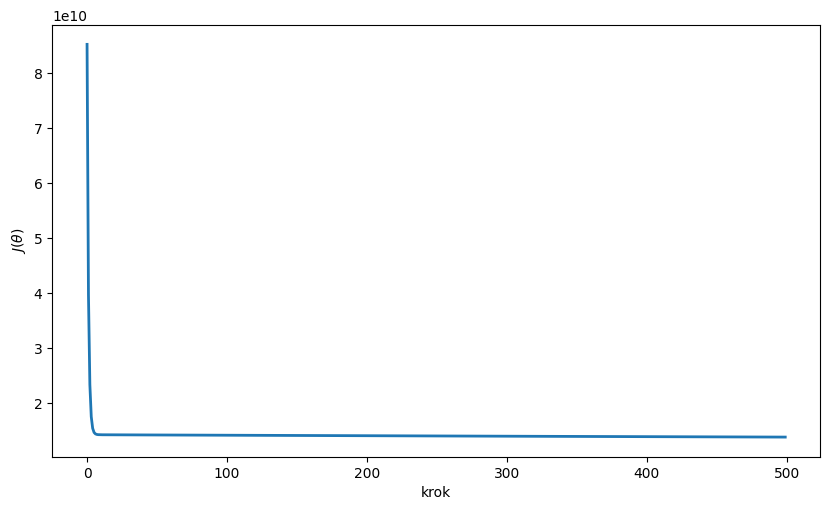

In [20]:
costchangeplot(history)



Jak temu zaradzić?

Spróbujemy przekształcić dane tak, żeby funkcja kosztu miała „ładny”, regularny kształt.

### Skalowanie

Będziemy dążyć do tego, żeby każda z cech przyjmowała wartości w podobnym zakresie.

W tym celu przeskalujemy wartości każdej z cech, dzieląc je przez wartość maksymalną:

$$ \hat{x_i}^{(j)} := \frac{x_i^{(j)}}{\max_j x_i^{(j)}} $$

In [21]:
X_scaled = X / np.amax(X, axis=0)

show_mins_and_maxs(X_scaled)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

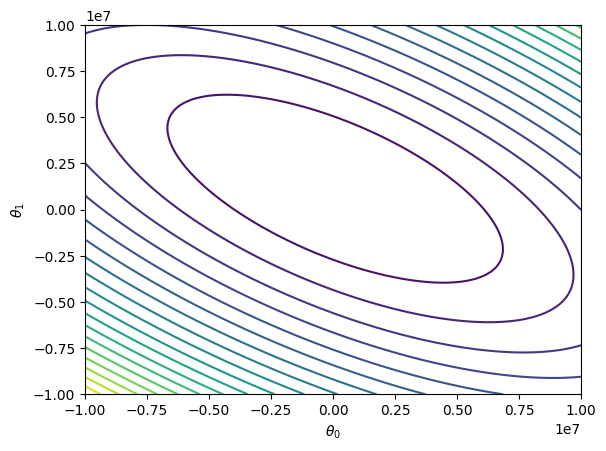

In [22]:
contour_plot(X_scaled[:, [0, 2, 3]], y)


Teraz możemy użyć większej długości kroku $\alpha$, dzięki czemu algorytm szybciej znajdzie rozwiązanie.

In [23]:
theta_start = np.zeros((n + 1, 1))
theta_best, history = gradient_descent(
    J, dJ, theta_start, X_scaled, y, alpha=0.01, eps=0.1
)
print(f"Liczba kroków: {len(history)}")
print(f"Koszt: {history[-1][0]}")


Liczba kroków: 82456
Koszt: 10324856880.491594


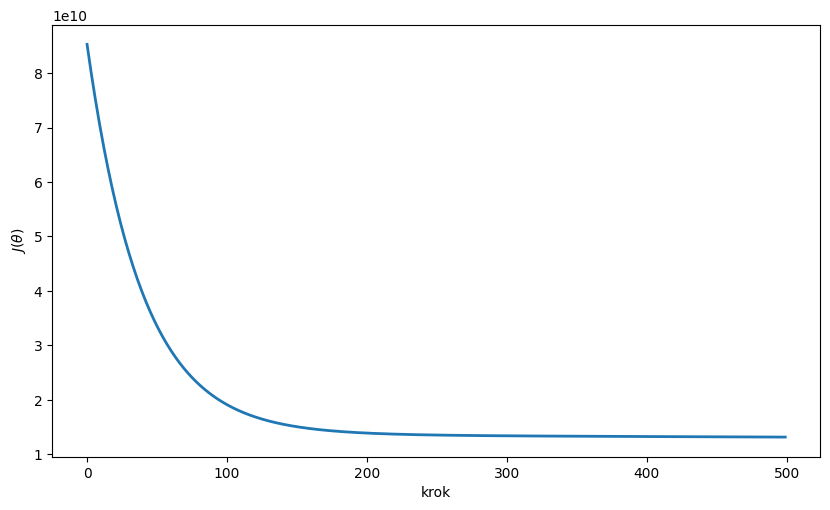

In [24]:
costchangeplot(history)


### Normalizacja średniej

Będziemy dążyć do tego, żeby dodatkowo średnia wartość każdej z cech była w okolicach $0$.

W tym celu oprócz przeskalowania odejmiemy wartość średniej od wartości każdej z cech:

$$ \hat{x_i}^{(j)} := \frac{x_i^{(j)} - \mu_i}{\max_j x_i^{(j)}} $$

In [25]:
X_normalized = (X - np.mean(X, axis=0)) / np.amax(X, axis=0)

show_mins_and_maxs(X_normalized)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

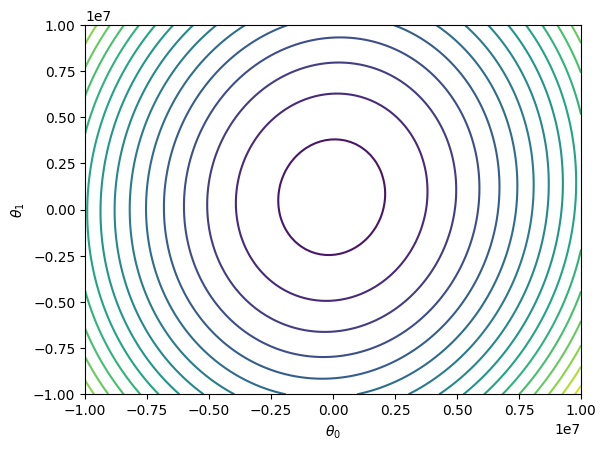

In [26]:
contour_plot(X_normalized[:, [0, 2, 3]], y)


Teraz funkcja kosztu ma wykres o bardzo regularnym kształcie – algorytm gradientu prostego zastosowany w takim przypadku bardzo szybko znajdzie minimum funkcji kosztu.

In [27]:
theta_start = np.zeros((n + 1, 1))
theta_best, history = gradient_descent(
    J, dJ, theta_start, X_normalized, y, alpha=0.1, eps=0.1
)
print(f"Liczba kroków: {len(history)}")
print(f"Koszt: {history[-1][0]}")


Liczba kroków: 9511
Koszt: 80221516127.09409


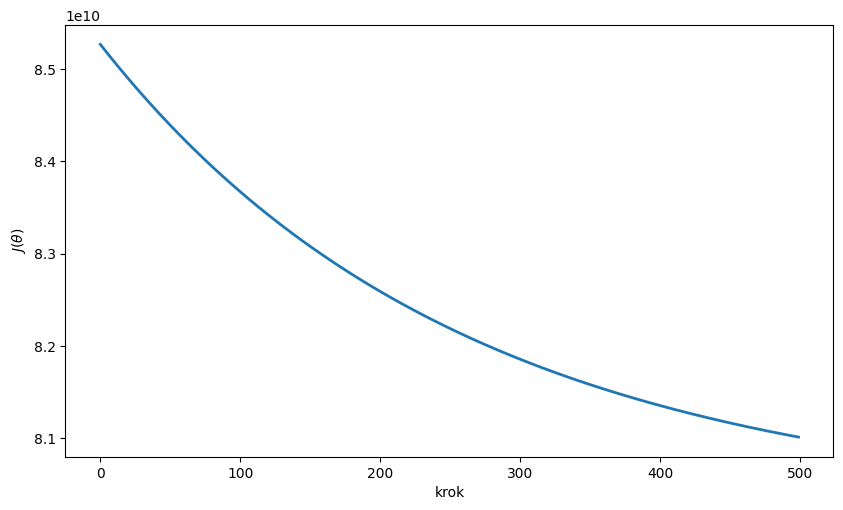

In [28]:
costchangeplot(history)
